In [21]:
import torch
from torch import nn
import numpy as np
import os
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms 
from utils.graph_utils import lossGraph
%matplotlib inline

SEED = 42
THRESHOLD = 0.5

np.random.seed(SEED)

In [22]:
data_dir = 'data'

In [23]:
image_height = 256
image_width = 256
batch_size = 16

In [24]:
transform = transforms.Compose([
  transforms.Resize(size=(image_height, image_width)),
  transforms.ToTensor()
])

In [25]:
dataset = datasets.ImageFolder(os.path.join(data_dir), transform=transform)

In [26]:
training_size = int(len(dataset)*0.8) #80% of data
testing_size = len(dataset) - training_size #20% of data

In [27]:
training_data, testing_data = random_split(dataset, [training_size, testing_size])

In [28]:
train_dataloader = DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=testing_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [29]:
print(f"train_dataloader iterable length: {len(train_dataloader)}")
print(f"test_dataloader iterable length: {len(test_dataloader)}")

train_dataloader iterable length: 21
test_dataloader iterable length: 5


dataloader size: 336
X shape before: (3, 256, 256)
X shape after: (256, 256, 3)


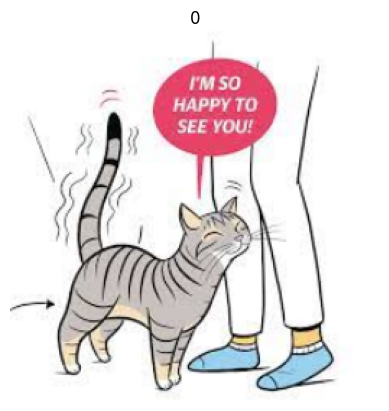

In [30]:
X, y = train_dataloader.dataset[335]
print(f"dataloader size: {len(train_dataloader.dataset)}")
print("X shape before:", X.numpy().shape)

#tranpose((1,2,0)) set index 1 shape to x, set index 2 shape to y, set index 0 shape to z
X = X.numpy().transpose((1, 2, 0)) 
# X = X.squeeze().permute(1,2,0) also works

print("X shape after:", X.shape)

#Must pass dimension in form of (M, N) / (M, N, 3) / (M, N, 4)
plt.imshow(X)
plt.title(y)
plt.axis('off')
plt.show()

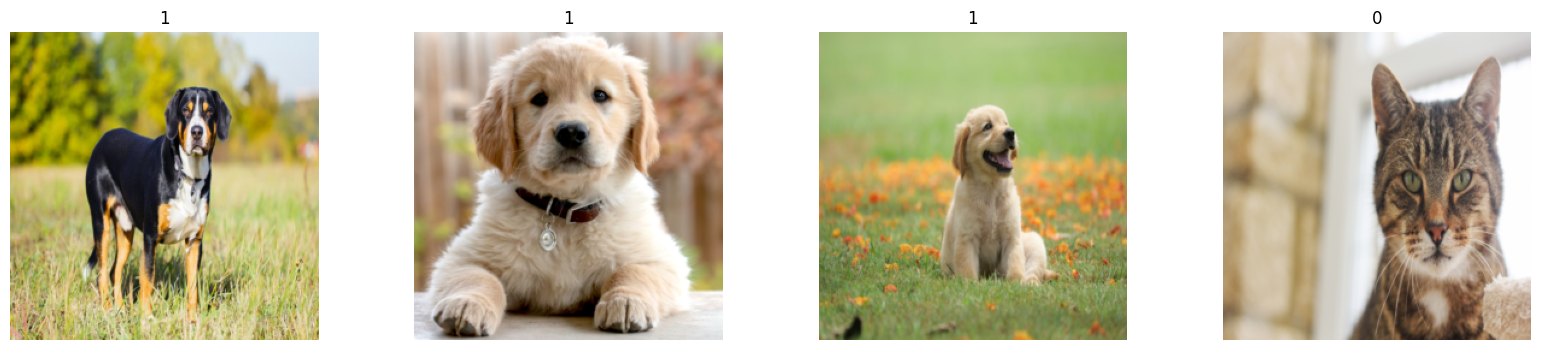

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
for i in range(4):
  X, y = train_dataloader.dataset[i]
  X = X.numpy().transpose((1, 2, 0))
  ax[i].imshow(X)
  ax[i].set_title(y)
  ax[i].axis('off')
plt.show()

In [32]:
for X, y in train_dataloader:
  print(f"[batch_size, channel, height, width]: [{X.shape[0]}, {X.shape[1]}, {X.shape[2]}, {X.shape[3]}]")
  print(f"y shape: {y.shape}")
  break

[batch_size, channel, height, width]: [16, 3, 256, 256]
y shape: torch.Size([16])


In [33]:
device = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else
  "cpu"
)
print(f"Using {device} device")

Using cpu device


In [34]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(
      #(256,256,3)
      nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=1, padding=1),
      #(256,256,16)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2)),
      #(128,128,16)
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=1),
      #(128,128,32)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2)),
      #(64,64,32)
      nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=1, padding=1),
      #(64,64,16)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2)),
      #(32,32,16)
      nn.Dropout(0.2),
      nn.Flatten(),
      #Input FC layer = 32*32*16
      nn.Linear(16384, 256),
      nn.ReLU(),
      nn.Linear(256, 1)
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=16384, out_features=256, bias=True)
    (12): ReLU()
    (13): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [35]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [36]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  train_loss, num_correct = 0, 0
  model.train()
  
  for batch, (X, y) in enumerate(dataloader):
    X, y, X.to(device), y.to(device)
    y = y.type(torch.float)

    pred = model(X).reshape(16,)
    pred = nn.Sigmoid()(pred)
    
    loss = loss_fn(pred, y)
    train_loss += loss.item()
    num_correct += ((pred > THRESHOLD) == y).type(torch.float).sum().item()
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    if batch % 10 == 0:
      loss, current = loss.item(), (batch+1) * len(X)
      print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
  avgTrainingLoss = train_loss / len(dataloader)
  trainingAccuracy = (num_correct / size) * 100
  return avgTrainingLoss, trainingAccuracy

In [37]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  number_batches = len(dataloader)

  model.eval()

  test_loss, num_correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y = y.type(torch.float)
      
      pred = model(X).reshape(16,)
      pred = nn.Sigmoid()(pred)

      test_loss += loss_fn(pred, y).item()
      num_correct += ((pred > THRESHOLD) == y).type(torch.float).sum().item()

  avgTestingLoss = test_loss / number_batches
  testingAccuracy = (num_correct / size) * 100
  print(f"Test Error \n Accuracy: {testingAccuracy:.1f}%, Avg Loss: {avgTestingLoss:>8f} \n")

  return avgTestingLoss, testingAccuracy

In [38]:
def main():  
  epochs = 20
  training_loss, testing_loss = [], []
  training_accuracy, testing_accuracy = [], []

  for t in range(epochs):
    print(f"Epoch {t+1} \n -------------------------------")
    avgTrainingLoss, trainingAccuracy = train(train_dataloader, model, loss_fn, optimizer)
    training_loss.append(avgTrainingLoss)
    training_accuracy.append(trainingAccuracy)

    avgTestingLoss, testingAccuracy = test(test_dataloader, model, loss_fn)
    testing_loss.append(avgTestingLoss)
    testing_accuracy.append(testingAccuracy)
    
  lossGraph(training_loss, testing_loss, training_accuracy, testing_accuracy, epochs)

  print(f"Execution finished")

Epoch 1 
 -------------------------------


Loss: 0.692754 [   16/  336]
Loss: 0.669347 [  176/  336]
Loss: 0.677606 [  336/  336]
Test Error 
 Accuracy: 42.9%, Avg Loss: 0.696893 

Epoch 2 
 -------------------------------
Loss: 0.636397 [   16/  336]
Loss: 0.689843 [  176/  336]
Loss: 0.682592 [  336/  336]
Test Error 
 Accuracy: 53.6%, Avg Loss: 0.672918 

Epoch 3 
 -------------------------------
Loss: 0.663334 [   16/  336]
Loss: 0.681949 [  176/  336]
Loss: 0.669527 [  336/  336]
Test Error 
 Accuracy: 58.3%, Avg Loss: 0.656420 

Epoch 4 
 -------------------------------
Loss: 0.662466 [   16/  336]
Loss: 0.651804 [  176/  336]
Loss: 0.700710 [  336/  336]
Test Error 
 Accuracy: 63.1%, Avg Loss: 0.661375 

Epoch 5 
 -------------------------------
Loss: 0.608212 [   16/  336]
Loss: 0.486321 [  176/  336]
Loss: 0.575761 [  336/  336]
Test Error 
 Accuracy: 70.2%, Avg Loss: 0.550126 

Epoch 6 
 -------------------------------
Loss: 0.435284 [   16/  336]
Loss: 0.492291 [  176/  336]
Loss: 0.357080 [  336/  336]
Test Error 
 

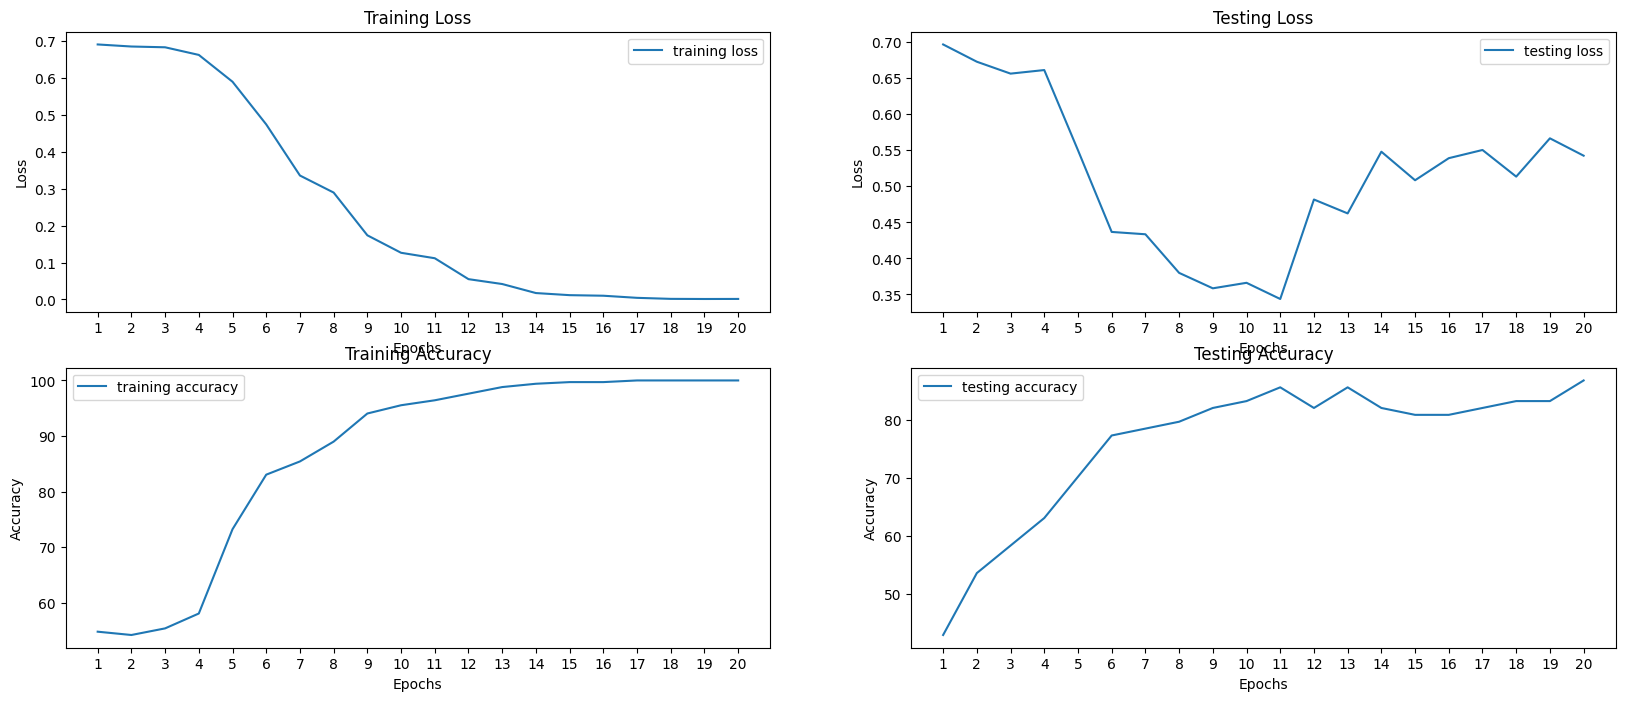

Execution finished


In [39]:
if __name__ == "__main__":
  main()

In [ ]:
torch.save(model, "models/pytorchmodels/simplemodel.pth")

In [40]:
"""
Other fixes:
- Implement Validation Data Statistics Later, but may need to allocate more data
"""

'\nOther fixes:\n- Implement Validation Data Statistics Later, but may need to allocate more data\n'